In [9]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Set the TF log level to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf

# Import Sionna
import sionna as sn

# For plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# For saving complex Python data structures efficiently
import pickle

# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

# For ONNX / TensorRT export
# import tf2onnx
# import onnx

# Set seed for reproducible results
sn.phy.config.seed = 42

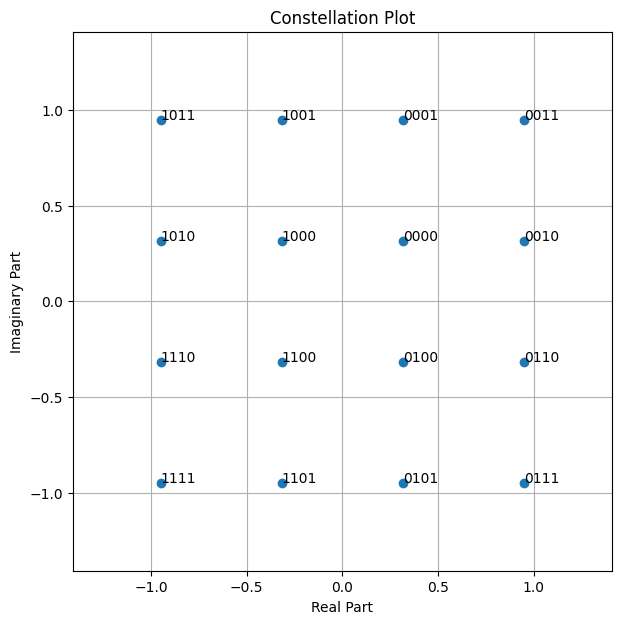

In [14]:
# Let's visualize all possible symbols for a 16-QAM
NUM_BITS_PER_SYMBOL = 4
mapper = sn.phy.mapping.Mapper(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                           constellation_type="qam")
demapper = sn.phy.mapping.Demapper(demapping_method="app",
                               num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                               constellation_type="qam")
mapper.constellation.show();

In [15]:
# Binary source to generate uniform i.i.d. bits
binary_source = sn.phy.mapping.BinarySource()

# AWGN channel
awgn_channel = sn.phy.channel.AWGN()

BATCH_SIZE = 128 # How many examples are processed by Sionna in parallel
EBN0_DB = 17.0 # Eb/N0 in dB

no = sn.phy.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

bits = binary_source([BATCH_SIZE, 1200]) # Blocklength
x = mapper(bits)
y = awgn_channel(x, no)

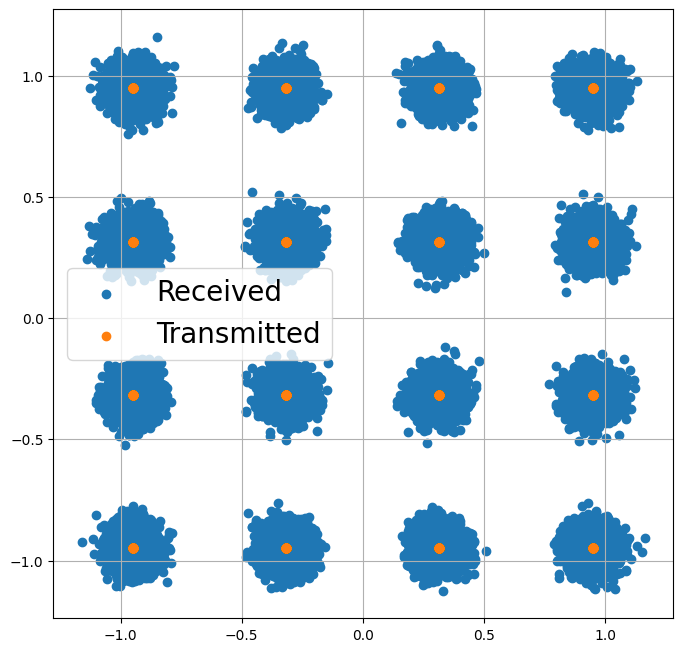

In [16]:
# Let's visualize the received symbols
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1.0)
plt.grid(True)
plt.scatter(tf.math.real(y), tf.math.imag(y), label='Received')
plt.scatter(tf.math.real(x), tf.math.imag(x), label='Transmitted')
plt.legend(fontsize=20);

In [17]:
bits = np.array([[0,0,0,1]])
print("Original bits:", bits)
x = mapper(bits)
print("Complex-valued symbol:", x.numpy())
# Add some noise
no = 0.05 # Noise variance
y = awgn_channel(x, no)
print("Received noisy symbol: ", y.numpy())
llr = demapper(y, no)
print("LLRs after demapping:", llr.numpy())

Original bits: [[0 0 0 1]]
Complex-valued symbol: [[0.31622776+0.94868326j]]
Received noisy symbol:  [[0.6098989+0.91612023j]]
LLRs after demapping: [[-15.877344   -30.353188    -0.57064176   7.1762123 ]]


### couldn't load exactly what they have given in the notebook

In [32]:
MAX_LINES = 1000000 # Stop after this many imported lines

# Depends on config that was used for data capture
fn_input = 'demapper_in.txt'
fn_output = 'demapper_out.txt'

# Read training data from data dump
def read_training_data(in_file, element_shape):
    with open(in_file) as f:
        lines = f.readlines()
    result = None
    i = 0
    while i < len(lines):
        try:
            i = lines.index('QAM16\n', i)
        except ValueError as e:
            break
        num = int(lines[i+1])
        #if num > 30:
        #    print(num)
        data = np.fromstring(' '.join(lines[i+2:i+2+num]), sep=' ', dtype=np.int16).reshape(num, *element_shape)
        if result is None:
            result = data
        else:
            result = np.concatenate((result, data))
        i += 2 + num
        if i>MAX_LINES:
            break
    return result

def int16_to_float16(symbols_i):
    return np.ldexp(symbols_i.astype(np.float32), -8).astype(np.float16)

def float16_to_int16(llrs_h):
    return np.rint(np.ldexp(llrs_h.astype(np.float32), 8)).astype(np.int16)

def norm_int16_to_float16(symbols_i, magnitudes):
    args = symbols_i.astype(np.float32)
    if magnitudes is not None:
        args = args / magnitudes.astype(np.float32)
    return np.ldexp(args, 7).astype(np.float16)

data_in = read_training_data(fn_input, (2, 2))
data_out = read_training_data(fn_output, (4,))
assert(data_in.shape[0] == data_out.shape[0])

print("data_in.shape: ", data_in.shape)
print("data_out.shape: ", data_out.shape)

print("First 5 input symbols:", data_in[0:5,:])
print("First 5 output symbols:", data_out[0:5,:])

AttributeError: 'NoneType' object has no attribute 'shape'

### Modified version of the above cell

In [33]:
# --- demapper_loader.py ---
import os, re
import numpy as np
from typing import List, Tuple, Dict, Optional

# ---------------- basic parsing ----------------
def _strip_comment(s: str) -> str:
    return s.split('#', 1)[0].strip()

def _next_nonempty(lines: List[str], i: int) -> int:
    n = len(lines)
    while i < n and not _strip_comment(lines[i]):
        i += 1
    return i

def _read_block(lines: List[str], i: int) -> Tuple[int, Optional[Dict], Optional[np.ndarray]]:
    n = len(lines)
    i = _next_nonempty(lines, i)
    if i >= n or i + 3 >= n:
        return n, None, None

    time_res_s = _strip_comment(lines[i]); i += 1
    ts_s       = _strip_comment(lines[i]); i += 1
    mod_s      = _strip_comment(lines[i]); i += 1
    num_s      = _strip_comment(lines[i]); i += 1

    try:
        time_res = float(time_res_s)
        timestamp = float(ts_s)
    except ValueError:
        return i, None, None

    mod = mod_s.upper()
    if mod not in ("QPSK", "QAM16"):
        raise ValueError(f"Unknown modulation '{mod_s}'")

    try:
        num_symbols = int(num_s)
    except ValueError:
        raise ValueError(f"Malformed symbol count '{num_s}'")

    rows = []
    for _ in range(num_symbols):
        if i >= n:
            raise ValueError("Unexpected EOF inside data block")
        vals_line = _strip_comment(lines[i]); i += 1
        if not vals_line:
            raise ValueError("Empty data line inside block")
        arr = np.fromstring(vals_line, sep=' ', dtype=np.int32)
        if arr.size == 0:
            ints = re.findall(r'[-+]?\d+', vals_line)
            if not ints:
                raise ValueError("No integers found on a data line")
            arr = np.array([int(x) for x in ints], dtype=np.int32)
        rows.append(arr)

    data = np.vstack(rows)  # (num_symbols, width)
    meta = {
        "time_res": time_res,
        "timestamp": timestamp,
        "mod": mod,
        "num_symbols": num_symbols,
        "width": int(data.shape[1]),
    }
    return i, meta, data

def read_demapper_blocks(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    with open(path, 'r', newline=None, encoding='utf-8', errors='replace') as f:
        lines = f.readlines()
    i = 0
    while i < len(lines):
        j, meta, data = _read_block(lines, i)
        if meta is None:
            i += 1
            continue
        yield meta, data
        i = j

# --------------- shaping helpers ----------------
def _pad_qpsk_to_qam16_llr(y2: np.ndarray) -> np.ndarray:
    """Map (N,2) -> (N,4) by zero-filling the 'inner bits'."""
    N = y2.shape[0]
    Y = np.zeros((N, 4), dtype=y2.dtype)
    Y[:, 0] = y2[:, 0]   # place as outer bit 0
    Y[:, 3] = y2[:, 1]   # place as outer bit 3
    return Y

def _make_ref_rows(n: int, value: int = 28, dtype=np.int32) -> np.ndarray:
    """Create (n,2) array of [value, value] rows."""
    return np.full((n, 2), value, dtype=dtype)

# --------------- main API ----------------
def load_in_out(
    in_path: str = "demapper_in.txt",
    out_path: str = "demapper_out.txt",
    ref_value: int = 28,           # this gives you the [28, 28] row
    pad_qpsk_to_qam16: bool = True # ensures data_out has 4 cols
):
    in_blocks  = list(read_demapper_blocks(in_path))
    out_blocks = list(read_demapper_blocks(out_path))
    if not in_blocks:
        raise ValueError(f"{in_path}: no valid blocks found")
    if not out_blocks:
        raise ValueError(f"{out_path}: no valid blocks found")

    pairs = []
    for k in range(min(len(in_blocks), len(out_blocks))):
        meta_in,  X = in_blocks[k]   # (Ni, 2) expected
        meta_out, Y = out_blocks[k]  # (No, 2 or 4)

        if X.shape[1] != 2:
            raise ValueError(f"{in_path} block {k}: expected width=2 (I,Q), got {X.shape[1]}")

        # Normalize Y to width 4 if needed
        if Y.shape[1] == 2 and pad_qpsk_to_qam16:
            Y = _pad_qpsk_to_qam16_llr(Y)
        elif Y.shape[1] not in (2, 4):
            raise ValueError(f"{out_path} block {k}: unexpected width {Y.shape[1]}")

        # Align symbol counts (truncate to shorter if needed)
        n = min(X.shape[0], Y.shape[0])
        if n == 0:
            continue
        X = X[:n]
        Y = Y[:n]

        # Build (n, 2, 2): first row is I,Q; second row is [ref_value, ref_value]
        ref = _make_ref_rows(n, ref_value, dtype=X.dtype)
        X22 = np.stack([X, ref], axis=1)  # (n, 2, 2)

        pairs.append((X22, Y))

    if not pairs:
        raise ValueError("No aligned IN/OUT pairs found")

    data_in  = np.concatenate([p[0] for p in pairs], axis=0)  # (N, 2, 2)
    data_out = np.concatenate([p[1] for p in pairs], axis=0)  # (N, 4) if padded
    return data_in, data_out

# --------------- example run ----------------
if __name__ == "__main__":
    data_in, data_out = load_in_out(
        in_path="demapper_in.txt",
        out_path="demapper_out.txt",
        ref_value=28,               # -> second row becomes [28,28]
        pad_qpsk_to_qam16=True      # -> data_out width 4
    )

    print("data_in.shape: ", data_in.shape)   # (N, 2, 2)
    print("data_out.shape:", data_out.shape)  # (N, 4)
    print("First 5 input symbols:", data_in[:5])
    print("First 5 output symbols:", data_out[:5])


data_in.shape:  (96, 2, 2)
data_out.shape: (96, 4)
First 5 input symbols: [[[  1  -2]
  [ 28  28]]

 [[ -3  -2]
  [ 28  28]]

 [[  6  -7]
  [ 28  28]]

 [[  3  -1]
  [ 28  28]]

 [[-18   8]
  [ 28  28]]]
First 5 output symbols: [[ 0  0  0 -1]
 [-1  0  0 -1]
 [ 0  0  0 -1]
 [ 0  0  0 -1]
 [-3  0  0  1]]


Avg. power after norm: 0.20148276020216516


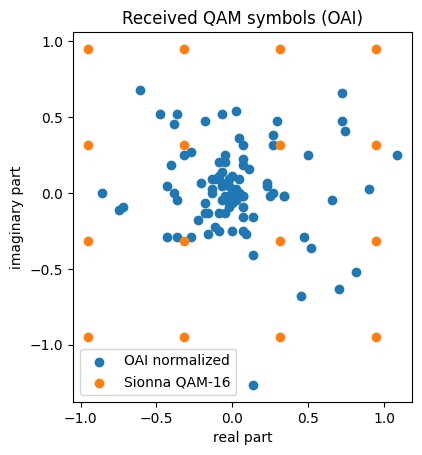

In [34]:
from matplotlib import pyplot as plt

x = data_in[:10000,...]
# OAI uses h as decision region between inner and outer bits
# We scale the received symbols y back such that y_n = y / h
y_n = x[:,0,0]/x[:,1,0] + 1.j*x[:,0,1]/x[:,1,1]

# This normalizes the first decision bound to 1,
# i.e., the center between inner and out constellation points.
# In the Sionna definition (i.e., power normalized QAM),
# the inner/outer points are at 0.3162278 and 0.9486833, respectively.
# Thus we need to scale y_n by s = 0.9486833 - 0.3162278
s = 0.9486833 - 0.3162278 # outer - inner constellation point
y = y_n * s

# Calculate average power of received symbols after normalization
avg_power = np.mean(np.abs(y)**2)

# Keep in mind there is some noise variance
print("Avg. power after norm:", avg_power)

# And plot results
plt.scatter(y.real, y.imag, label="OAI normalized")
plt.title("Received QAM symbols (OAI)")
plt.ylabel("imaginary part")
plt.xlabel("real part");
plt.gca().set_aspect('equal', adjustable='box');

# Overlay with Sionna constellations
c = sn.phy.mapping.Constellation("qam", 4).points.numpy()
plt.scatter(c.real, c.imag, label="Sionna QAM-16")
plt.legend();

/tmp/ipykernel_516757/1543957726.py:13: RuntimeWarning: invalid value encountered in cast
  llr_ref = np.reshape(llr_.astype(int), (-1,4))


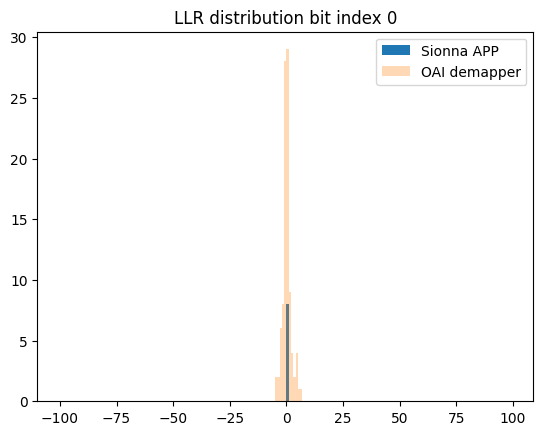

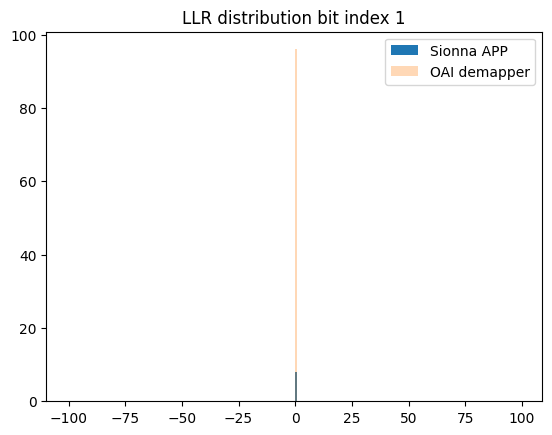

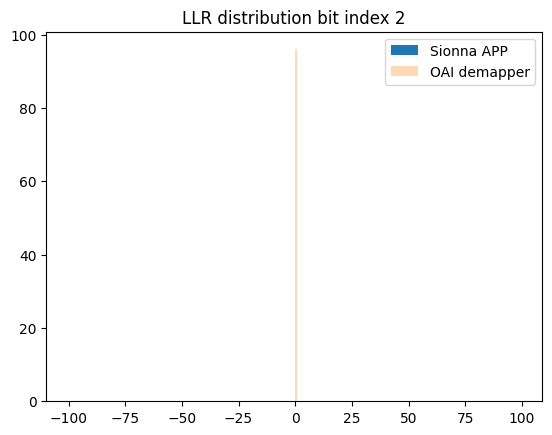

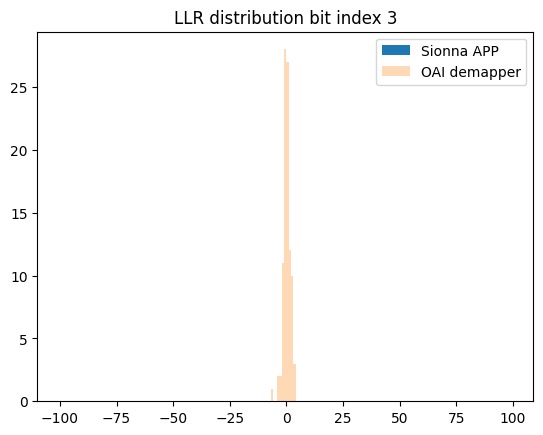

In [35]:
demapper = sn.phy.mapping.Demapper("app", "qam", 4)

y_tf = tf.constant(y, tf.complex64)
# avg_power is signal power ps + no where ps = 1
ps = 1. # Signal power
no = tf.constant(avg_power-ps, tf.float32)

llr = -1* demapper(y_tf, no) # Flip sign due to Sionna's logit definition

# Scale llrs
llr_ = llr.numpy()

llr_ref = np.reshape(llr_.astype(int), (-1,4))

llr_oai = data_out[:llr_ref.shape[0],...]

# And plot distributions
r = np.arange(-100, 100, 1)

for bit_idx in range(4):
    plt.figure()
    plt.hist(llr_ref[:,bit_idx], bins=r, label="Sionna APP")

    plt.hist(llr_oai[:,bit_idx], bins=r, alpha=0.3, label="OAI demapper")
    plt.legend();
    plt.title(f"LLR distribution bit index {bit_idx}")